In [1]:
from dataclasses import dataclass
from typing import Callable

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

from plotting import label_axes
from utils import gauss_cgs

# Magnetic field

Uniform $B_0$ field in X direction with Alfven-wave perturbation with small amplitude $\delta B << B_0$

TODO: $\delta B$ must be a spectrum not a monochromatic wave!


In [2]:
B0 = 1e-6 * gauss_cgs
deltaB = 1e-2 * B0

# plasma density
n_IMP = 1 / u.cm**3
rho_IMP = n_IMP * const.m_p
v_A = (B0 / np.sqrt(rho_IMP)).to(u.km / u.s)
print(f"v_A = {v_A:.2f} ({(v_A / const.c).decompose():.2e} * speed of light)")


@dataclass
class Particle:
    E: u.Quantity[u.eV]
    theta: float

    gamma: float
    v: u.Quantity[u.km / u.s]

    R_L: u.Quantity[u.au]
    Omega_L: u.Quantity[1 / u.day]
    T_L: u.Quantity[u.day]

    k_res: u.Quantity[1 / u.au]
    w_res: u.Quantity[1 / u.kyr]
    lambda_res: u.Quantity[u.au]

    def __str__(self) -> str:
        return "\n".join(
            [
                f"proton with E = {self.E:.2f} pitch angle = {180 * self.theta / np.pi}",
                f"v = {self.v / const.c:.2e} c; gamma = {self.gamma:.2e}",
                f"gyration params: R = {self.R_L:.2f} T = {self.T_L:.2f}",
                f"resonance conditions: k = {self.k_res:.2e}; wavelength = {self.lambda_res:.2f}",
            ]
        )

    @classmethod
    def from_energy_pitch_angle(cls, E: u.Quantity[u.eV], theta: float):
        gamma = (E / (const.m_p * const.c**2)).decompose()
        v = const.c * np.sqrt(1 - gamma ** (-2))
        R_L = (
            (gamma * const.m_p * v * np.sin(theta)) * const.c / (const.e.gauss * B0)
        ).to(u.au)
        k_res = (np.tan(theta) / R_L).to(1 / u.au)
        Omega_L = v * np.sin(theta) / R_L

        return Particle(
            E=E,
            theta=theta,
            gamma=gamma,
            v=v,
            R_L=R_L,
            Omega_L=Omega_L,
            T_L=(2 * np.pi / Omega_L).to(u.day),
            k_res=k_res,
            w_res=(k_res * v_A).to(1 / u.kyr),
            lambda_res=1 / k_res,
        )


print(Particle.from_energy_pitch_angle(E=1 * u.TeV, theta=np.pi / 4))

v_A = 7.73 km / s (2.58e-05 * speed of light)
proton with E = 1.00 TeV pitch angle = 45.0
v = 1.00e+00 c; gamma = 1.07e+03
gyration params: R = 157.67 AU T = 8.09 d
resonance conditions: k = 6.34e-03 1 / AU; wavelength = 157.67 AU


In [3]:
def B_field(
    x: u.Quantity[u.au],
    y: u.Quantity[u.au],
    z: u.Quantity[u.au],
    t: u.Quantity[u.kyr],
    k: u.Quantity[1 / u.au],
    phase: float = 0.0,
) -> tuple[u.Quantity[gauss_cgs], ...]:
    assert x.shape == y.shape == z.shape
    B_x = B0 * np.ones_like(x).value
    w = (k * v_A).to(1 / u.kyr)
    B_y = deltaB * np.cos((k * x - w * t).decompose().value + phase)
    B_z = deltaB * np.sin((k * x - w * t).decompose().value + phase)
    return B_x, B_y, B_z

# Full numerical integration to obtain particle trajectory

To pass the problem to the ODE solver, we need to rewrite it in standard form
$\frac{d \vec{\theta}}{dt} = f(t, \vec{\theta})$ with initial condition
$\vec \theta(t_0) = \vec \theta_0$. For our problem we can use

$$
\theta = \begin{pmatrix}
v_x \\
v_y \\
v_z \\
x \\
y \\
z \\
\end{pmatrix}
$$

Then,

$$
f = \begin{pmatrix}
\frac{q}{c m \gamma} (v_y B_z - v_z B_y) \\
\frac{q}{c m \gamma} (-v_x B_z + v_z B_x) \\
\frac{q}{c m \gamma} (v_x B_y - v_y B_x) \\
v_x \\
v_y \\
v_z \\
\end{pmatrix}


$$


In [4]:
from typing import Literal
from tqdm import tqdm


L_UNIT = u.au
T_UNIT = u.day
V_UNIT = L_UNIT / T_UNIT
A_UNIT = L_UNIT / (T_UNIT**2)


@dataclass
class State:
    vx: u.Quantity[V_UNIT]
    vy: u.Quantity[V_UNIT]
    vz: u.Quantity[V_UNIT]

    x: u.Quantity[L_UNIT]
    y: u.Quantity[L_UNIT]
    z: u.Quantity[L_UNIT]

    def __post_init__(self) -> None:
        self.vx = self.vx.to(V_UNIT)
        self.vy = self.vy.to(V_UNIT)
        self.vy = self.vy.to(V_UNIT)
        self.x = self.x.to(L_UNIT)
        self.y = self.y.to(L_UNIT)
        self.z = self.z.to(L_UNIT)

    @classmethod
    def initial(cls, particle: Particle, phase: float | None) -> "State":
        v_trans = particle.v * np.sin(particle.theta)
        phi = phase if phase is not None else 2 * np.pi * np.random.random()
        return State(
            vx=particle.v * np.cos(particle.theta),
            vy=v_trans * np.cos(phi),
            vz=v_trans * np.sin(phi),
            x=0 * L_UNIT,
            y=0 * L_UNIT,
            z=0 * L_UNIT,
        )

    @classmethod
    def unpack(cls, arr: np.ndarray, v: u.Quantity[V_UNIT]) -> "State":
        vy, vz, x, y, z = arr
        vy = vy * V_UNIT
        vz = vz * V_UNIT
        return State(
            vx=np.sqrt(v**2 - vy**2 - vz**2),
            vy=vy,
            vz=vz,
            x=x * L_UNIT,
            y=y * L_UNIT,
            z=z * L_UNIT,
        )

    def pack(self) -> np.ndarray:
        return np.array(
            [
                self.vy.to(V_UNIT).value,
                self.vz.to(V_UNIT).value,
                self.x.to(L_UNIT).value,
                self.y.to(L_UNIT).value,
                self.z.to(L_UNIT).value,
            ]
        )


def get_ode_rhs(
    particle: Particle, k: u.Quantity[1 / u.au], B_phase: float, perturbed: bool
):
    force_norm = const.e.gauss / (const.c * const.m_p * particle.gamma)

    def f(
        t: float, params: np.ndarray, pbar: tqdm | None = None, verbose: bool = False
    ) -> np.ndarray:
        if pbar is not None:
            pbar.update()
        if verbose:
            print()
            print("t =", t)
            print("params =", params)
        if not np.all(np.isfinite(params)):
            raise ValueError(f"got NaN params: {params}")

        t = t * T_UNIT
        state = State.unpack(params, v=particle.v)
        if verbose:
            print(f"state: {state}")

        Bx, By, Bz = B_field(state.x, state.y, state.z, t, k=k, phase=B_phase)
        if verbose:
            print(f"B = [{Bx}, {By}, {Bz}]")

        result = np.array(
            [
                (force_norm * (state.vz * Bx - (state.vx * Bz if perturbed else 0)))
                .to(A_UNIT)
                .value,
                (force_norm * (-state.vy * Bx + (state.vx * By if perturbed else 0)))
                .to(A_UNIT)
                .value,
                state.vx.value,
                state.vy.value,
                state.vz.value,
            ]
        )
        if verbose:
            print("result:", result)
        if not np.all(np.isfinite(result)):
            raise RuntimeError(f"Non-finite values in RHS: {result}")
        return result

    return f


def pitch_angle(particle: Particle, solution: np.ndarray) -> np.ndarray:
    vy = solution[0, :] * V_UNIT
    vz = solution[1, :] * V_UNIT
    v_trans = np.sqrt(vy**2 + vz**2)
    sin_theta = (v_trans / particle.v).decompose().value
    return (180 * np.arcsin(sin_theta) / np.pi) * u.deg

### Unperturbed field solution (sanity check)

Should be a basic Larmor rotation...

State(vx=<Quantity 149.94104993 AU / d>, vy=<Quantity 86.56850554 AU / d>, vz=<Quantity 0. m / s>, x=<Quantity 0. AU>, y=<Quantity 0. AU>, z=<Quantity 0. AU>)


4430eval [00:01, 2313.83eval/s]


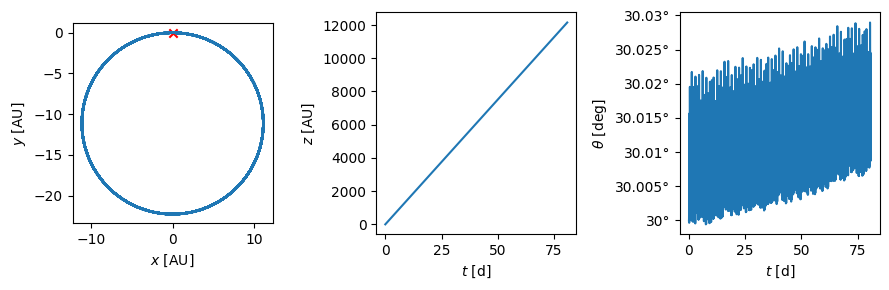

In [5]:
E = 100 * u.GeV
gamma = E / (const.m_p * const.c**2)
theta = np.pi / 6
particle = Particle.from_energy_pitch_angle(E=E, theta=theta)
init = State.initial(particle, phase=0)
print(init)

B_phase = 0.0
k = particle.k_res 

t_max = 100 * particle.T_L
t_eval = (
    np.arange(0, t_max.to(T_UNIT).value, particle.T_L.to(T_UNIT).value / 31.41562)
    * T_UNIT
)
with tqdm(unit="eval") as pbar:
    unperturbed_solution = solve_ivp(
        fun=get_ode_rhs(particle=particle, k=k, B_phase=B_phase, perturbed=False),
        t_span=(0, t_max.to(T_UNIT).value),
        y0=init.pack(),
        args=[pbar, False],
        t_eval=t_eval,
    )

_, axes = plt.subplots(ncols=3, figsize=(9, 3))
axes[0].plot(
    unperturbed_solution.y[3, :] * L_UNIT, unperturbed_solution.y[4, :] * L_UNIT
)
axes[0].scatter(0, 0, marker="x", color="r")
axes[0].set_aspect(1)
label_axes(axes[0], "x", "y")
axes[1].plot(t_eval, unperturbed_solution.y[2, :] * L_UNIT)
label_axes(axes[1], "t", "z")
axes[2].plot(t_eval, pitch_angle(particle, unperturbed_solution.y))
label_axes(axes[2], "t", "\\theta")
plt.tight_layout()

### QLT solution

4436eval [00:01, 2654.78eval/s]
/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_17476/3209352775.py:20: RuntimeWarning: invalid value encountered in divide
  (perturbed_solution.y[2, :] - unperturbed_solution.y[2, :])


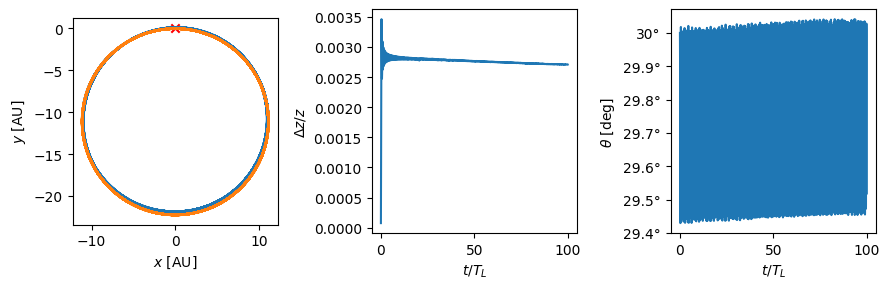

In [6]:
with tqdm(unit="eval") as pbar:
    perturbed_solution = solve_ivp(
        fun=get_ode_rhs(particle=particle, k=k, B_phase=B_phase, perturbed=True),
        t_span=(0, t_max.to(T_UNIT).value),
        y0=init.pack(),
        args=[pbar, False],
        t_eval=t_eval,
    )

_, axes = plt.subplots(ncols=3, figsize=(9, 3))
axes[0].plot(perturbed_solution.y[3, :] * L_UNIT, perturbed_solution.y[4, :] * L_UNIT)
axes[0].plot(
    unperturbed_solution.y[3, :] * L_UNIT, unperturbed_solution.y[4, :] * L_UNIT
)
axes[0].scatter(0, 0, marker="x", color="r")
axes[0].set_aspect(1)
label_axes(axes[0], "x", "y")
axes[1].plot(
    t_eval / particle.T_L,
    (perturbed_solution.y[2, :] - unperturbed_solution.y[2, :])
    / unperturbed_solution.y[2, :],
)
label_axes(axes[1], "t / T_L", "\\Delta z / z")
axes[2].plot(t_eval / particle.T_L, pitch_angle(particle, perturbed_solution.y))
label_axes(axes[2], "t / T_L", "\\theta")
plt.tight_layout()

# QLT equation for pitch angle

$$
\frac{d \mu}{dt} = \Omega \frac{\delta B}{B_0} \sqrt{1 - \mu^2} \cos(\varphi + \Omega t - k v \mu t)
$$

In [27]:
def get_mu_rhs(
    particle: Particle,
    k: u.Quantity[1 / u.pc] | Literal["resonant"],
    phase_diff: float,
    mu_0: float,
) -> tuple[Callable, float]:

    def mu_rhs(
        t: float, mu: np.ndarray, pbar: tqdm | None = None, verbose: bool = False
    ) -> np.ndarray:
        if pbar is not None:
            pbar.update()
        t = t * T_UNIT
        result = (
            particle.Omega_L
            * (deltaB / B0)
            * np.sqrt(1 - mu**2)
            * np.cos(
                # some initial phase difference between particle Larmor rotation and deltaB
                phase_diff
                + (
                    ((particle.Omega_L - k * particle.v * mu) * t)
                    .to(u.dimensionless_unscaled)
                    .value
                    # resonant condition = this term vanishes
                    if k != "resonant"
                    else 0
                )
            )
        ).to(1 / T_UNIT)
        if verbose:
            print(f"result: {result}")
        return result

    return (
        mu_rhs,
        (
            min(
                (
                    1e-3
                    * (2 * np.pi / np.abs(particle.Omega_L - k * particle.v * mu_0[0]))
                    .to(T_UNIT)
                    .value
                ),
                1e-3 * particle.T_L.to(T_UNIT).value,
            )
            if k != "resonant"
            else particle.T_L.to(T_UNIT).value
        ),
    )

In [28]:
theta0 = np.pi / 4
particle = Particle.from_energy_pitch_angle(E=100 * u.GeV, theta=theta0)
mu_0 = np.array([np.cos(theta0)])
T_L_ = (particle.T_L).to(T_UNIT).value

/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
231it [00:00, 6045.36it/s]
228it [00:00, 8705.28it/s]
265it [00:00, 7861.00it/s]
240it [00:00, 8427.30it/s]


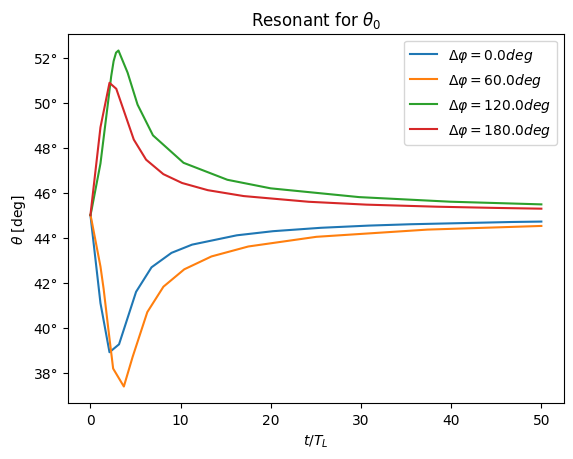

In [29]:
_, ax = plt.subplots()
for phase_diff in np.linspace(0, np.pi, 4):
    fun, step = get_mu_rhs(
        particle=particle,
        k=particle.k_res,
        phase_diff=phase_diff,
        mu_0=mu_0,
    )
    with tqdm() as pbar:
        solution = solve_ivp(
            fun=fun,
            t_span=(0, 50 * T_L_),
            y0=mu_0,
            args=[pbar, False],
            first_step=step,
            method="Radau",
        )
    ax.plot(
        (solution.t * T_UNIT / particle.T_L).decompose(),
        180 * np.arccos(solution.y[0, :]) / np.pi * u.deg,
        label=f"$\\Delta \\varphi = {{{180 * phase_diff / np.pi * u.deg:.1f}}}$",
    )
label_axes(ax, "t / T_L", "\\theta")
ax.legend()
ax.set_title("Resonant for $\\theta_0$")
plt.show()

249it [00:00, 7918.88it/s]
248it [00:00, 9323.68it/s]
236it [00:00, 9477.93it/s]
272it [00:00, 9269.10it/s]
282it [00:00, 9562.26it/s]
308it [00:00, 9709.04it/s]
301it [00:00, 9190.33it/s]


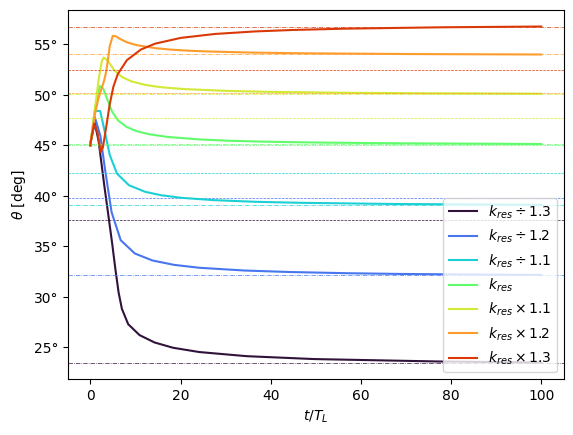

In [40]:
_, ax = plt.subplots()
multipliers = (1.1, 1.2, 1.3)
total = len(multipliers) * 2 + 1
cmap = matplotlib.colormaps["turbo"]
idx = 0
for power in (-1, 0, 1):
    for multiplier in sorted(multipliers, reverse=power < 0) if power != 0 else [1]:
        color = cmap(idx / total)
        k = particle.k_res * multiplier**power
        hypothetis_theta_lim = np.arctan(particle.R_L * k)
        fun, step = get_mu_rhs(
            particle=particle,
            phase_diff=np.pi,
            mu_0=mu_0,
            k=k,
        )
        with tqdm() as pbar:
            solution = solve_ivp(
                fun=fun,
                t_span=(0, 100 * T_L_),
                y0=mu_0,
                args=[pbar, False],
                first_step=step,
                method="Radau"
            )
        ax.plot(
            (solution.t * T_UNIT / particle.T_L).decompose(),
            180 * np.arccos(solution.y[0, :]) / np.pi * u.deg,
            label=(
                f"$ k_{{res}} {'\\times' if power == 1 else '\\div'} {multiplier} $"
                if multiplier != 1
                else "$k_{res}$"
            ),
            color=color,
        )
        ax.axhline(hypothetis_theta_lim, color=color, linewidth=0.5, linestyle="--")
        theta_lim = 180 * np.arccos(solution.y[0, -1]) / np.pi * u.deg
        ax.axhline(theta_lim, color=color, linewidth=0.5, linestyle="-.")
        idx += 1
label_axes(ax, "t / T_L", "\\theta")
ax.legend()
# ax.set_title("")
plt.show()